# Exact Indexing of Dynamic Time Warping

**Artur Dandolini Pescador**

This notebook tries to implement the Exact Indexing of Dynamic Time Warping proposed 

[1] Eamonn Keogh and Chotirat Ann Ratanamahatana. 2005. Exact Indexing of Dynamic Time Warping. Knowledge and Information Systems 7, 358–386. Springer. [Link to the paper](https://link.springer.com/article/10.1007/s10115-004-0154-9).


## Packages

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [82]:
%load_ext autoreload
%autoreload 2

from data_preprocessing import load_and_process_data, normalize_timeseries
from plotting import plot_timeseries, plot_query_database_with_bounds, plot_sequence_with_paa, plot_sequence_with_bounds_and_paa, plot_matches_knn_search, plot_range_search_results
from dtw_functions import lb_keogh, paa, lb_kim, lb_yi
from indexed_structure import IndexedStructure
from indexing import knn_search, range_search

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
%reload_ext autoreload

## 1. Loading Data

In [84]:
# Carregando e processando os dados
timeseries = load_and_process_data('sunspots.csv')

In [85]:
timeseries.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


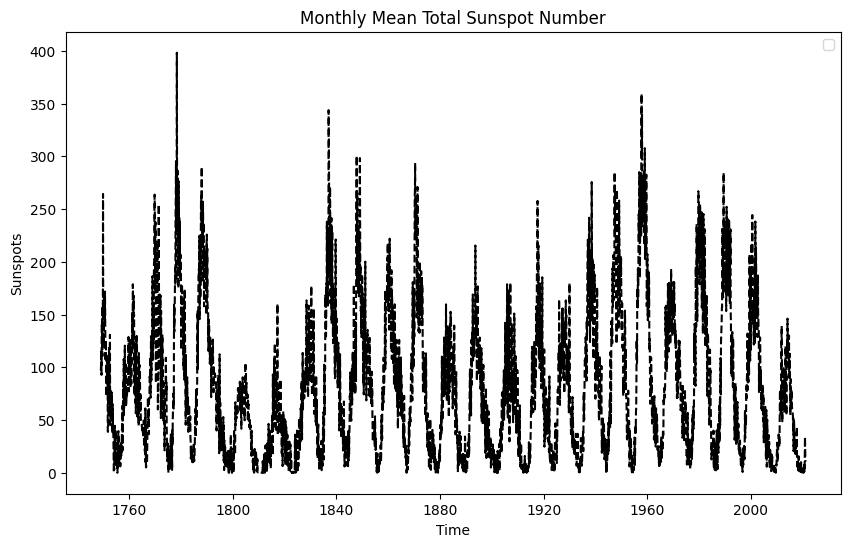

In [86]:
# Plotando a série temporal
plot_timeseries(timeseries.index, timeseries['Monthly Mean Total Sunspot Number'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


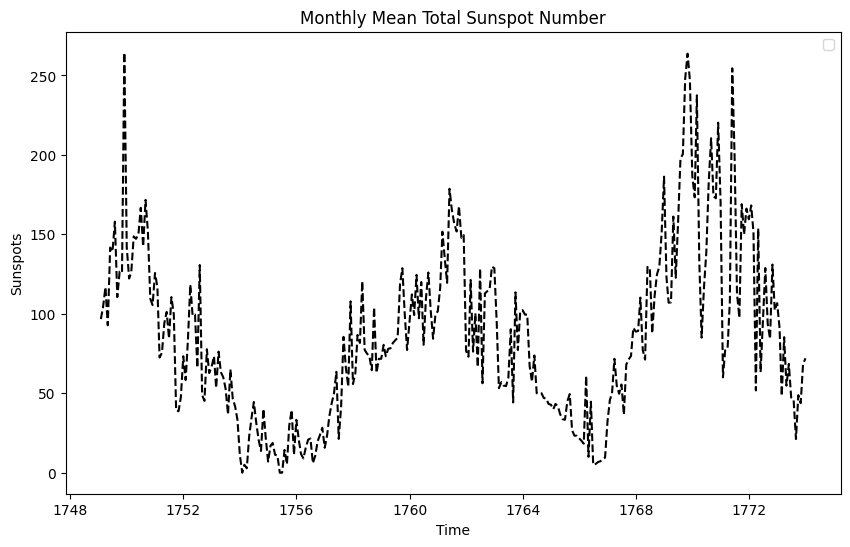

In [87]:
# zoom into the plot, the seasonality is roughly 11 years
plot_timeseries(timeseries.index[:300], timeseries['Monthly Mean Total Sunspot Number'][:300])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


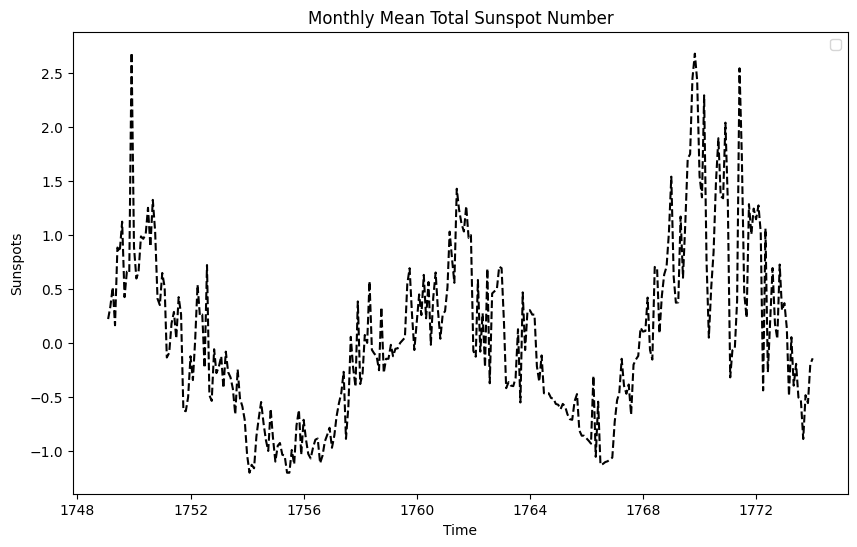

In [88]:
#  normalizando a série temporal
timeseries = normalize_timeseries(timeseries)


# Plotando a série temporal normalizada
plot_timeseries(timeseries.index[:300], timeseries['Monthly Mean Total Sunspot Number'][:300])

## 2. Lower Bouding the DTW distance

### 2.1 Proposed Lower Bounding Measure

$$U_i = max({q_{i-r} : q_{i+r}})$$
$$L_i = min({q_{i-r} : q_{i+r}})$$

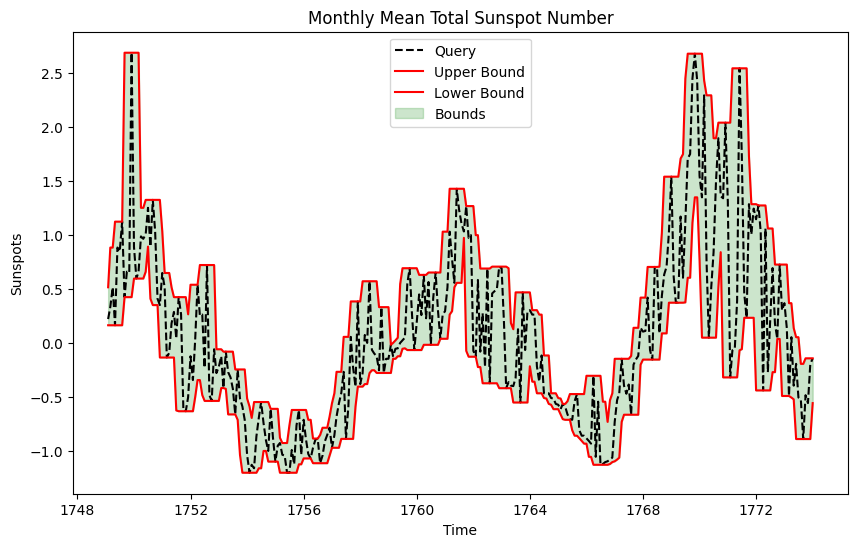

In [89]:
sunspots = np.array(timeseries['Monthly Mean Total Sunspot Number'])

# query and database sequences
x = sunspots[:300] # query
y = sunspots[300:600] # database
r = 3 # warping window

# Calculate the Upper and Lower sequences using the provided formula
U = [max(x[max(i-r, 0):min(i+r+1, len(x))]) for i in range(len(x))]
L = [min(x[max(i-r, 0):min(i+r+1, len(x))]) for i in range(len(x))]

# Plot the sequences
plot_timeseries(timeseries.index[:300], x, label='Query', Upper=U, Lower=L)


Now that we have defined U and L, we can define the lower bounding function LB_Keogh. It is defined as follows:

$$ \text{LB\_Keogh}(Q,C) = \sqrt{\sum_{i=1}^{n} 
\begin{cases} 
(c_i - U_i)^2 & \text{if } c_i > U_i \\
(c_i - L_i)^2 & \text{if } c_i < L_i \\
0 & \text{otherwise}
\end{cases}
} $$

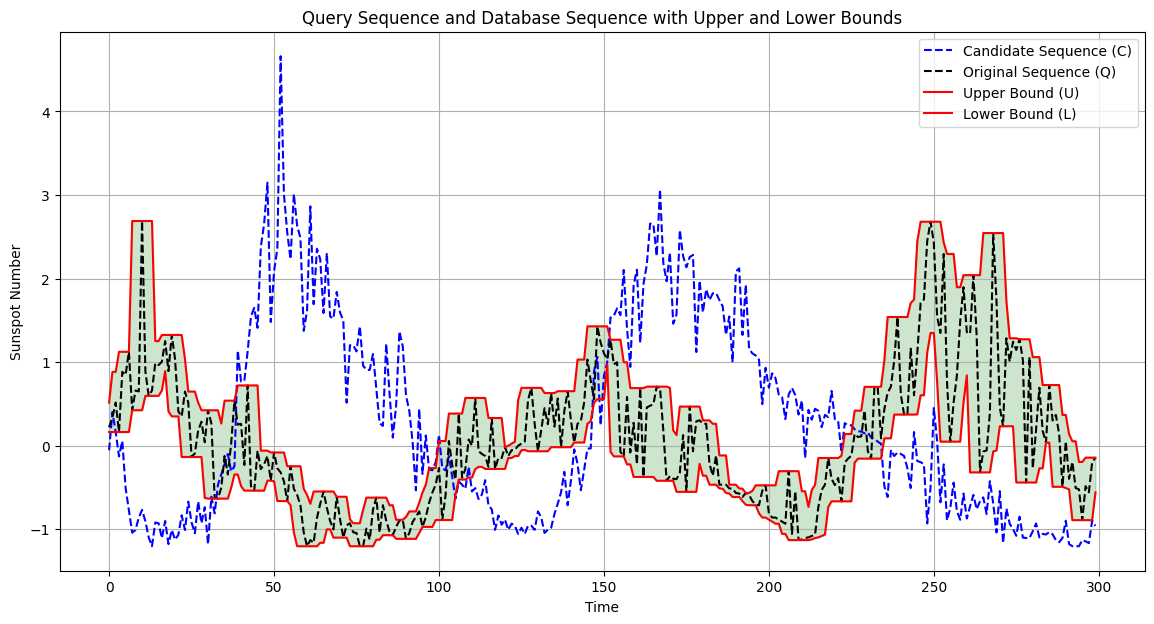

In [90]:
plot_query_database_with_bounds(y, x, U, L)

In summary, the plot visualizes how LB_Keogh computes a lower bound on the DTW distance by considering only the points of C that fall outside the bounding envelopes of Q. This can significantly speed up the process of DTW because it allows us to avoid full DTW calculations if the lower bound is greater than some threshold of interest.

## 3. Indexing DTW

We have denoted a time serie as $C = c_1, c_2, c_n, \ldots$.

Let $N$ be the dimensionality of the space we wish to index.

$$1 \leq N\leq n$$

A time series $C$ of length $n$ can be represented as a set of $N$-dimensional space by a vector:

$$ \bar{C} = (\bar{c_1}, \bar{c_2}, \ldots, \bar{c_N})$$

The $i$-th element of $\bar{C}$ is defined as:

$$\bar{c_i} = \frac{N}{n} \sum_{j=\frac{n}{N}(i-1)+1}^{\frac{n}{N}i} c_j$$

In [91]:
# plot the query sequence and the PAA
dim = 16
paa_original = paa(x, dim)
paa_candidate = paa(y, dim)

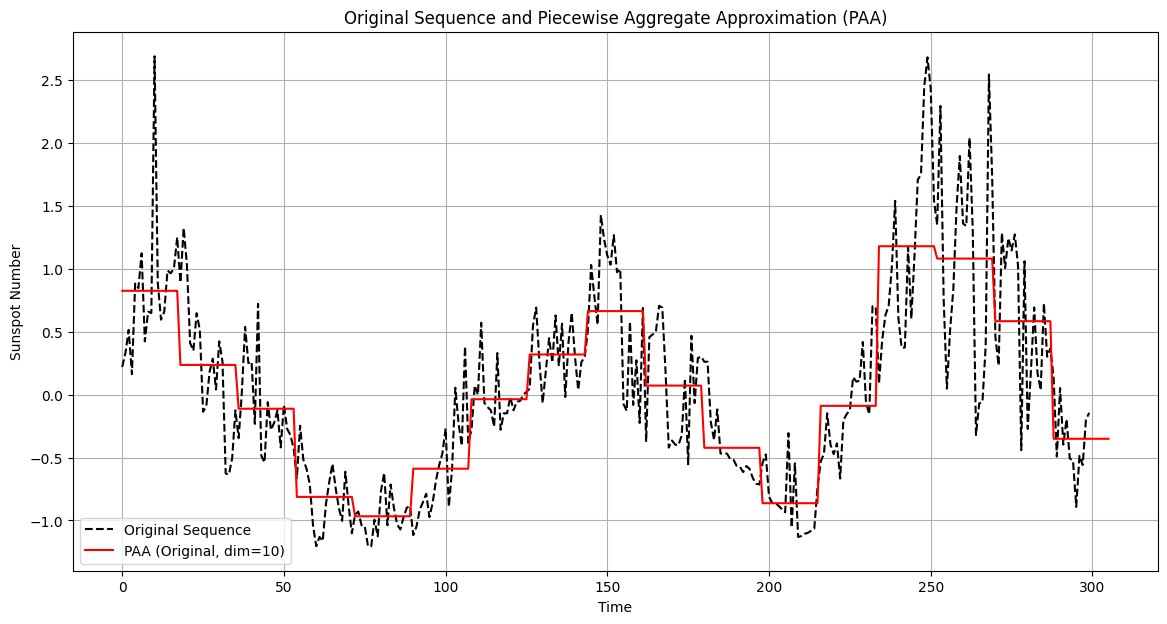

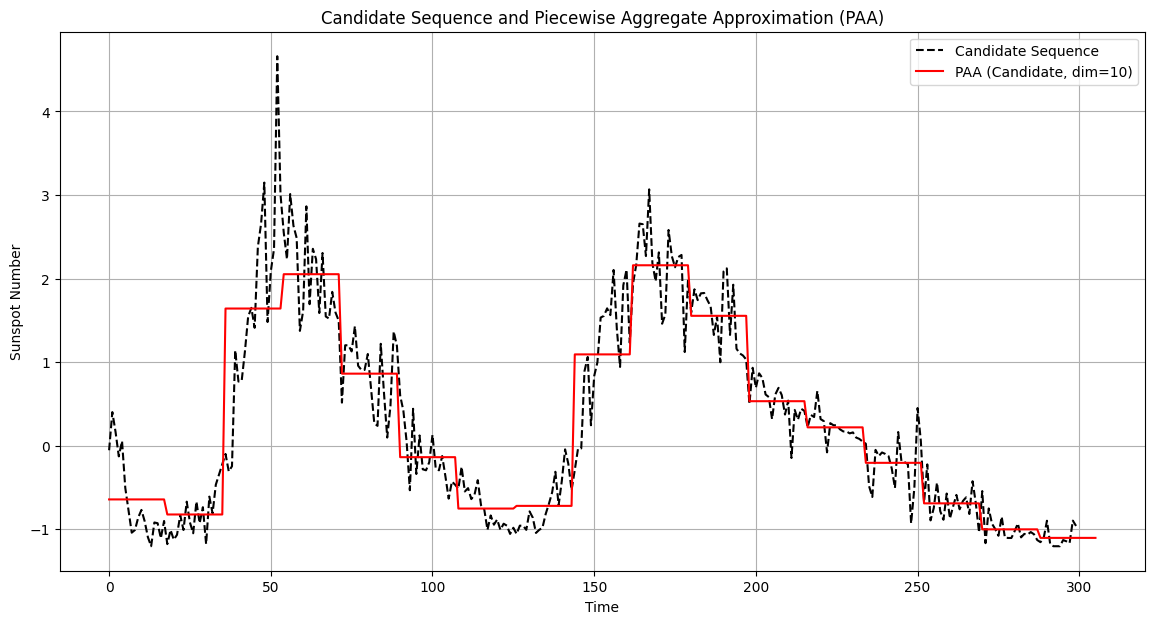

In [92]:
plot_sequence_with_paa(x, paa_original, 'Original')
plot_sequence_with_paa(y, paa_candidate, 'Candidate')

Given two original time series $C$ and $Q$, we can represent them as $\bar{C}$ and $\bar{Q}$ as described above.

### 3.1. Modifying PAA to index time-warped queries


Before we computed the lowering bounding measure LB_Keogh. However, calculating the LB_Keogh requires n values. Because n may be in the order of hundreds to thousands and multidimensional index structures begin to degrade rapidly somewhere above 16 dimensions, we need a way to create a lower, N-dimension version of the function, where N is a number that can be reasonably handled by a multidimensional index structure. We also need this lower dimension version of the function to lower bound LB_Keogh (and therefore, by transitivity, DTW).

Let's start by creating special piecewise aggregate approximations of U and L, which we will deonte as $\bar{U}$ and $\bar{L}$.

$$\hat{U_i} = max({U{_{\frac{n}{N}(i-1)+1}}, \dots, U{_{\frac{n}{N}(i)}}})$$

$$\hat{L_i} = min({L{_{\frac{n}{N}(i-1)+1}}, \dots, L{_{\frac{n}{N}(i)}}})$$

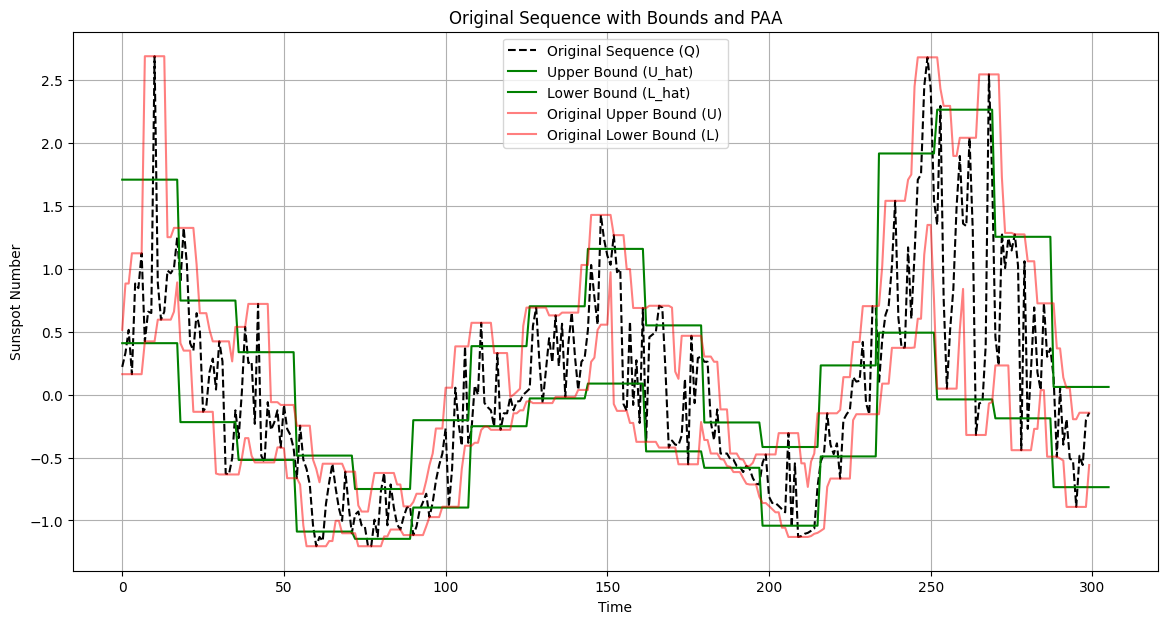

In [93]:
U_hat = paa(U, dim)
L_hat = paa(L, dim)

plot_sequence_with_bounds_and_paa(x, U, L, U_hat, L_hat)

We can now defined the low dimension version of LB_Keogh as follows, which is denoted as LB_PAA. Given a candidate sequence C, transformed to $\bar{C}$, and a query sequence Q, with its companion PAA functions $\hat{U}$ and $\hat{L}$, the following function lower bounds LB_Keogh:

$$ LB_{PAA}(Q,\bar{C}) = \sqrt{\sum_{i=1}^{N} 
\begin{cases} 
(\bar{c_i} - \hat{U_i})^2 & \text{if } \bar{c_i} > \hat{U_i} \\
(\bar{c_i} - \hat{L_i})^2 & \text{if } \bar{c_i} < \hat{L_i} \\
0 & \text{otherwise}

\end{cases}
} $$

Now, the final step is to define a $MINDIST$ function that can be used to index time series. The $MINDIST$ function is defined as follows:


$$ MINDIST(Q,R) = \sqrt{\sum_{i=1}^{N} \frac {n}{N}
\begin{cases} 
(l_i - \hat{U_i})^2 & \text{if } l_i > \hat{U_i} \\
(h_i - \hat{L_i})^2 & \text{if } h_i < \hat{L_i} \\
0 & \text{otherwise}
\end{cases}
} $$

where:

$L = {l_1, l_2, \ldots, l_N}$

$H = {h_1, h_2, \ldots, h_N}$

and R is the major diagonal.

By definition, R is the smallest rectangle that contains eacg PAA point $\bar{C} = {\bar{c_1}, \bar{c_2}, \ldots, \bar{c_N}}$ stored in $U$.

Now, that we defined $LB_{PAA}$ and $MINDIST(Q,R)$, we can introduce the K-NN algorithm.

A query $KNNSearch(Q, k)$  with a query sequence $Q$ and a parameter $k$, returns the $k$ nearest neighbors of $Q$ in the time series database. 

The distance of an object $C$ from $Q$ is defined by the $LB_{PAA}(Q,\bar{C})$ function, while the distance of a node $U$ from $Q$ is defined by the $MINDIST(Q,R)$ function of the minimum bouding rectangle (MBR) $R$ that contains $U$ from $Q$.

### 3.2. K-NN Search Algorithm

In [94]:
indexed_structure = IndexedStructure(paa_size=16)
for i in range(0, len(sunspots), 300):
    indexed_structure.insert(sunspots[i:i+300])

knn_search(indexed_structure, x, 3, U_hat=U_hat, L_hat=L_hat)

[(array([ 0.06217808,  0.23893649,  0.31995075,  0.17412507,  0.99899761,
          1.84743794,  1.35104143,  0.89146958,  0.36119438,  1.28033807,
          1.56904346,  0.51585798,  0.75595481,  1.23614847,  2.00210154,
          1.61617903,  1.23909444,  1.5646245 ,  2.393916  ,  1.4541505 ,
          1.09326876,  0.88115868,  1.12420148,  0.90619945,  0.89588854,
          0.58508835,  1.23762145,  1.177229  ,  0.88852361,  1.78409951,
          0.60718316,  1.17428303,  2.30406381,  1.65447668,  1.39670402,
          1.93876311,  1.51454295,  1.30243287,  0.96217294,  1.54842164,
          1.55725956,  0.69261638,  1.16691809,  1.38197415,  1.56315151,
          1.0225654 ,  0.96364593,  0.78836052,  0.76184676, -0.08953954,
          0.27870713,  0.2374635 ,  0.07396198,  0.54384473,  0.68525145,
          0.49523617, -0.04829592,  0.23599051,  0.0165155 , -0.14109408,
         -0.31196053, -0.1057424 , -0.10279642, -0.33258235, -0.13225616,
         -0.22505432,  0.02977238, -0.

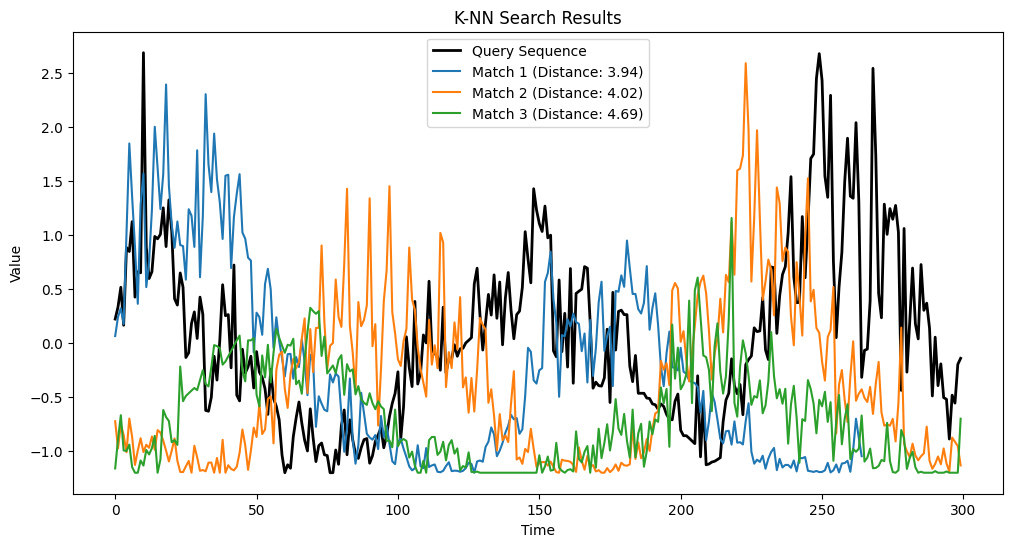

In [95]:
query_sequence = sunspots[:300]
U = [max(query_sequence[max(i-r, 0):min(i+r+1, len(query_sequence))]) for i in range(len(query_sequence))]
L = [min(query_sequence[max(i-r, 0):min(i+r+1, len(query_sequence))]) for i in range(len(query_sequence))]
U_hat = paa(U, 16)
L_hat = paa(L, 16)


knn_search_results = knn_search(indexed_structure, query_sequence, k=3, U_hat=U_hat, L_hat=L_hat)
plot_matches_knn_search(query_sequence, knn_search_results)

### 3.3. Range Search Algorithm

In [96]:
epsilon = 10
query_sequence = sunspots[:300]
query_paa = indexed_structure.paa(query_sequence)
results = range_search(query_paa, epsilon, indexed_structure.root, query_sequence, U_hat, L_hat)
print(f"Number of sequences found within epsilon range: {len(results)}")

Number of sequences found within epsilon range: 9


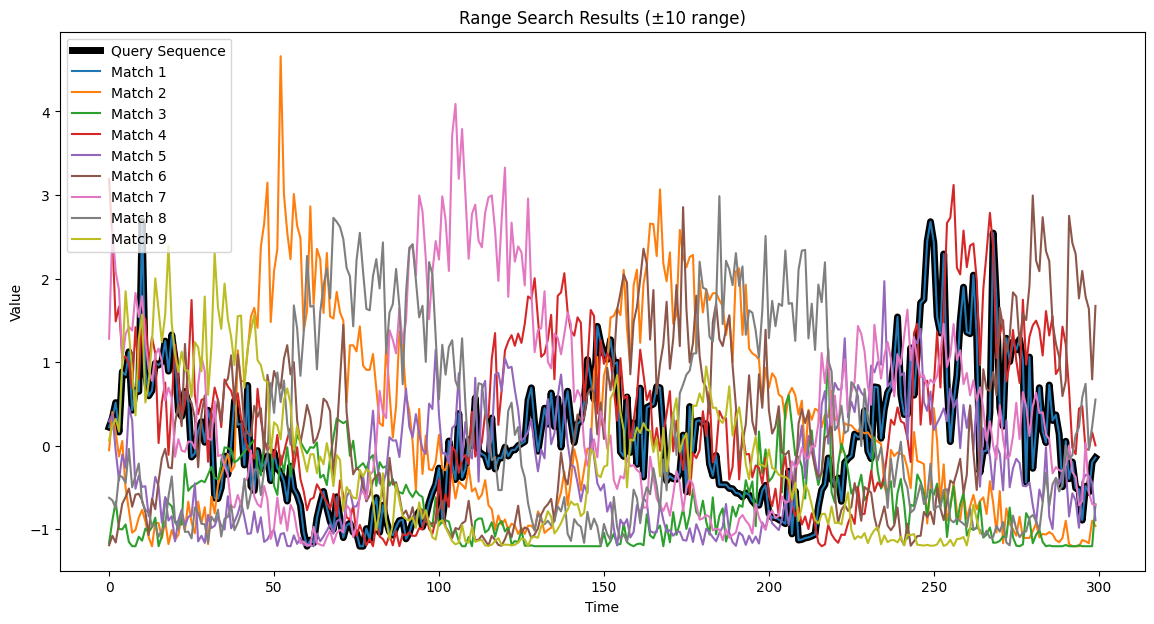

In [97]:
# If the list of results is not empty, plot the results
if results:
    plot_range_search_results(query_sequence, results)
else:
    print("No matches found within the specified epsilon range.")

In [98]:
from dtw_functions import lb_paa, dtw_distance
for entry in indexed_structure.root.entries[:10]: 
    lb_distance = lb_paa(query_paa, entry.paa_representation, U_hat, L_hat)
    actual_distance = dtw_distance(query_sequence, entry.original_sequence)
    print(f"LB_PAA: {lb_distance}, DTW: {actual_distance}")

    if actual_distance <= epsilon:
        print("A match should have been found here.")

LB_PAA: 2.7427834870161663, DTW: 0.0
A match should have been found here.
LB_PAA: 3.1729682076667993, DTW: 8.572376255507768
A match should have been found here.
LB_PAA: 4.688435447965529, DTW: 9.814380809195512
A match should have been found here.
LB_PAA: 2.98145725549059, DTW: 12.078723843815293
LB_PAA: 2.6621220119580067, DTW: 6.862251152499725
A match should have been found here.
LB_PAA: 3.7287294086701457, DTW: 5.577465958797036
A match should have been found here.
LB_PAA: 4.0177866933378, DTW: 10.044110828201385
LB_PAA: 3.0527409340390395, DTW: 8.55676434546958
A match should have been found here.
LB_PAA: 2.9667562354667063, DTW: 8.584740254292239
A match should have been found here.
LB_PAA: 3.238351618061785, DTW: 8.655176852564013
A match should have been found here.


Since our data has a large scale, even small percentage differences will result in a large DTW distances. Therefore, we normalize the data in order to make the data more comparable. Without normalization, it was necessary to use a really high epsilon value to find any matches in the algorithm range search.

## Experimental evaluation

### Tightness of the Lower Bound

In [99]:
# Perform the experiment
def perform_experiment_T(dataset, lb_func, num_sequences, sequence_length):
    results = []
    for _ in range(num_sequences):
        # Select two random sequences from the dataset
        seq1 = np.random.choice(dataset, size=sequence_length)
        seq2 = np.random.choice(dataset, size=sequence_length)

        # Calculate lower bounding distance and actual DTW distance
        if lb_func == lb_keogh:
            lb = lb_func(seq1, seq2, 3)
        else:
            lb = lb_func(seq1, seq2)
        dtw_dist = dtw_distance(seq1, seq2)

        # Calculate the tightness of the lower bound
        T = lb / dtw_dist if dtw_dist != 0 else 0
        results.append(T)

        return np.mean(results)

In [100]:
# Perform the experiment
num_sequences = 50
sequence_length = 256

# Calculate the average tightness of the lower bound
T_lb_keogh = perform_experiment_T(sunspots, lb_keogh, num_sequences, sequence_length)
T_lb_kim = perform_experiment_T(sunspots, lb_kim, num_sequences, sequence_length)
T_lb_yi = perform_experiment_T(sunspots, lb_yi, num_sequences, sequence_length)

print(f"Average tightness of the lower bound (Kim): {T_lb_kim}")
print(f"Average tightness of the lower bound (Yi): {T_lb_yi}")
print(f"Average tightness of the lower bound (Keogh): {T_lb_keogh}")

Average tightness of the lower bound (Kim): 0.06264912128485749
Average tightness of the lower bound (Yi): 0.054316870810023336
Average tightness of the lower bound (Keogh): 0.6485906537495106
